# Preparation before RNN learning

Due to the first 3 sections in Chapter 8 of book "Dive into Deep Learning".

## Sequence Model

In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l

print(f'Import PyTorch V{torch.__version__}')

Import PyTorch V1.12.1


Prepare sin sequence with white noise


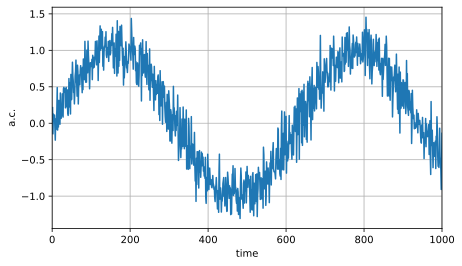

In [2]:
print('Prepare sin sequence with white noise')
seq_count = 1000 # count of sequence points
time = torch.arange(1, seq_count + 1, dtype=torch.float32) # time
seq = torch.sin(0.01 * time) + torch.normal(0, 0.2, (seq_count,)) # sin sequence
d2l.plot(time, [seq], 'time', 'a.c.', xlim=(0, seq_count), figsize=(7, 4))

In [3]:
print('prepare data')
tau = 4
features = torch.zeros((seq_count - tau, tau))
for i in range(tau):
    features[:, i] = seq[i: seq_count - tau + i]
labels = seq[tau:].reshape((-1, 1))
print(f'features {features.shape}, labels {labels.shape}')

prepare data
features torch.Size([996, 4]), labels torch.Size([996, 1])


In [4]:
from torch.utils.data import TensorDataset, DataLoader

batch_size, train_size = 16, 600
train_ds = TensorDataset(features[:train_size], labels[:train_size])
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

print(f'Take first {train_size} as training data, iterate them with batch size {batch_size}')

Take first 600 as training data, iterate them with batch size 16


In [5]:
def gen_seq_model():
    def init_weight(m):
        if isinstance(m, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
    model = torch.nn.Sequential(
        torch.nn.Linear(4, 10),
        torch.nn.ReLU(),
        torch.nn.Linear(10, 1),
    )
    model.apply(init_weight)
    return model

In [6]:
seq_model = gen_seq_model()
seq_loss = torch.nn.MSELoss(reduction='none')
opt = torch.optim.Adam(seq_model.parameters(), 0.01)

print(f'Prepare model: {seq_model}')
print(f'Prepare loss function: {seq_loss}')
print(f'Prepare trainer: {opt}')

Prepare model: Sequential(
  (0): Linear(in_features=4, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)
Prepare loss function: MSELoss()
Prepare trainer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


In [7]:
print('Start training')
for epoch in range(5):
    for X, y in train_loader:
        opt.zero_grad()
        loss = seq_loss(seq_model(X), y)
        loss.sum().backward()
        opt.step()
    print(f'epoch {epoch + 1}, ' f'loss: {d2l.evaluate_loss(seq_model, train_loader, seq_loss):f}')

Start training
epoch 1, loss: 0.065223
epoch 2, loss: 0.058310
epoch 3, loss: 0.052078
epoch 4, loss: 0.049708
epoch 5, loss: 0.048413


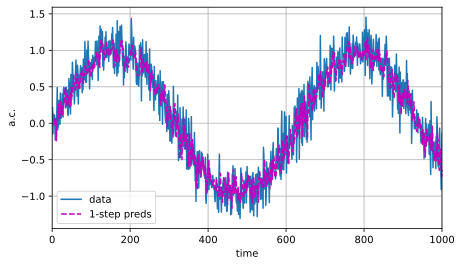

In [8]:
onestep_preds = seq_model(features)
d2l.plot([time, time[tau:]], 
         [seq.detach().numpy(), onestep_preds.detach().numpy()], 
         'time', 'a.c.', legend=['data', '1-step preds'], 
         xlim=[0, seq_count], figsize=(7, 4))